In [1]:
# needed installs
"""
!pip install scipy==1.8.0
!pip install networkx
!pip install matplotlib
!pip install nltk
"""

# needed imports and downloads
import nltk
nltk.download('vader_lexicon')
import networkx as nx
#from networkx.algorithms.community.centrality import girvan_newman
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import re
import random
from matplotlib.lines import Line2D

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\beenz\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# set seeds to ensure reproducibility

seed = 12345
random.seed(seed)
np.random.seed(seed)

## Dataframe creation and data cleaning

In [3]:
# loading the csv into a dataframe (load sentiment.csv into same directory as notebook or change working directory manually to ensure functionality!)
df = pd.read_csv(r'C:\Users\beenz\JupyterLab\FCSS\sentiment.csv')
df.head()

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets
0,0,2022-12-17 23:46:34+00:00,1604261802715611137,https://twitter.com/HaraldV7/status/1604261802...,HaraldV7,Twitter for Android,NaN,@MarcoBuschmann Die Straftaten machen die Poli...,0,0
1,1,2022-12-17 23:43:31+00:00,1604261035841568772,https://twitter.com/HeadSoccer_Main/status/160...,HeadSoccer_Main,Twitter for Android,Unbekannt,Bitte retweeten was das Zeug hält.\nOben die d...,12,8
2,2,2022-12-17 23:41:29+00:00,1604260523977183233,https://twitter.com/BunteRepDE/status/16042605...,BunteRepDE,Twitter for iPhone,NaN,#GrüneSekte + #LetzteGeneration https://t.co/e...,8,1
3,3,2022-12-17 23:34:04+00:00,1604258660133240832,https://twitter.com/emojizedcom/status/1604258...,emojizedcom,WP Plugin Dev Com,"Zurich, Switzerland","#Klimaaktivisten, #Klimakleber sind spinner!💻 ...",0,0
4,4,2022-12-17 23:23:23+00:00,1604255971630538752,https://twitter.com/PaulMll06935330/status/160...,PaulMll06935330,Twitter for Android,NaN,@ThatDataStuff @MDRAktuell Diese #LetzteGenera...,2,0


In [4]:
# check if there are duplicated rows in the dataframe
duplicateRows = df[df.duplicated()]

duplicateRows

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets


In [5]:
# define a regular expression to match usernames
username_regex = r'@(\w+)'

# apply the regular expression to each row of the 'tweet' column using the str.findall() method
df['interacted_user'] = df['tweet'].apply(lambda x: set(re.findall(username_regex, x)))

# print the first 5 rows of the updated dataframe
df.head()

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets,interacted_user
0,0,2022-12-17 23:46:34+00:00,1604261802715611137,https://twitter.com/HaraldV7/status/1604261802...,HaraldV7,Twitter for Android,NaN,@MarcoBuschmann Die Straftaten machen die Poli...,0,0,{MarcoBuschmann}
1,1,2022-12-17 23:43:31+00:00,1604261035841568772,https://twitter.com/HeadSoccer_Main/status/160...,HeadSoccer_Main,Twitter for Android,Unbekannt,Bitte retweeten was das Zeug hält.\nOben die d...,12,8,{}
2,2,2022-12-17 23:41:29+00:00,1604260523977183233,https://twitter.com/BunteRepDE/status/16042605...,BunteRepDE,Twitter for iPhone,NaN,#GrüneSekte + #LetzteGeneration https://t.co/e...,8,1,{}
3,3,2022-12-17 23:34:04+00:00,1604258660133240832,https://twitter.com/emojizedcom/status/1604258...,emojizedcom,WP Plugin Dev Com,"Zurich, Switzerland","#Klimaaktivisten, #Klimakleber sind spinner!💻 ...",0,0,{}
4,4,2022-12-17 23:23:23+00:00,1604255971630538752,https://twitter.com/PaulMll06935330/status/160...,PaulMll06935330,Twitter for Android,NaN,@ThatDataStuff @MDRAktuell Diese #LetzteGenera...,2,0,"{ThatDataStuff, MDRAktuell}"


In [6]:
# some users in interacted user are not in the username column
# this user need to be filtered out as to only have valid user to user interactions
unique_interacted_user =  set()

for in_set in df.interacted_user:
    for i in in_set: 
        unique_interacted_user.add(i)


username = set()
for i in df.username: 
    username.add(i)

# user that are mentioned in tweets but not part of the original dataset = non_user
non_user = set(unique_interacted_user.difference(username))

print(f" {len(unique_interacted_user)} number unique interacted_user")
print(f" {len(unique_interacted_user.difference(username))} number unique interacted_user not found in username column")
print(f" {len(non_user)} length non_user set to verify number of usernames not in username column")
print(f" user left: {len(unique_interacted_user)-len(non_user)}")


 1518 number unique interacted_user
 1132 number unique interacted_user not found in username column
 1132 length non_user set to verify number of usernames not in username column
 user left: 386


In [7]:
# new dataframe with only valid user in username and interacted_user columns
cleanedInteractedUserDF = df.copy()
cleanedInteractedUserDF['interacted_user'] = [set(x).difference(non_user) for x in cleanedInteractedUserDF['interacted_user']]

test_unique_interacted_user =  set()

for in_set in cleanedInteractedUserDF['interacted_user']:
    for i in in_set: 
        test_unique_interacted_user.add(i)
print(len(test_unique_interacted_user))

386


In [8]:
# some rows have now no interacted_user in order to have valid user to user interactions
# rows without interacted_user are filtered out
mask = cleanedInteractedUserDF['interacted_user'].apply(lambda x: len(x) == 0)

# filter the DataFrame using the mask
noEmptySetDF = cleanedInteractedUserDF[~mask]

# new dataframe with no empty interacted_user column
noEmptySetDF.head()

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets,interacted_user
0,0,2022-12-17 23:46:34+00:00,1604261802715611137,https://twitter.com/HaraldV7/status/1604261802...,HaraldV7,Twitter for Android,NaN,@MarcoBuschmann Die Straftaten machen die Poli...,0,0,{MarcoBuschmann}
5,5,2022-12-17 23:20:48+00:00,1604255318690516992,https://twitter.com/Ein_Trixi/status/160425531...,Ein_Trixi,Twitter for Android,NaN,@watch_union @_FriedrichMerz Es ist für Herrn ...,1,0,{watch_union}
7,7,2022-12-17 23:05:54+00:00,1604251567980412932,https://twitter.com/Nette_0870/status/16042515...,Nette_0870,Twitter Web App,Deutschland,@Michael47439567 @AufstandLastGen Die Rhetorik...,0,0,{AufstandLastGen}
8,8,2022-12-17 22:50:36+00:00,1604247719001952256,https://twitter.com/dingendorf/status/16042477...,dingendorf,Twitter for Android,"Montabaur, Deutschland","@Meikell56 Der Punkt ist doch, dass es so ist,...",3,0,{Meikell56}
12,12,2022-12-17 22:38:46+00:00,1604244741318758402,https://twitter.com/Kranich631/status/16042447...,Kranich631,Twitter Web App,NaN,@herbertEXgth @MarcoBuschmann Ich habe nicht g...,0,0,"{MarcoBuschmann, herbertEXgth}"


In [9]:
# check that our chosen hashtags are contained in the tweets 
# and save the cleaned dataframe in a new dataframe
pattern = '|'.join(['#letztegeneration', '#lastgeneration', '#klimakleber'])
df_cleaned = noEmptySetDF[noEmptySetDF['tweet'].str.contains(pattern, flags=re.IGNORECASE)]
df_cleaned

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets,interacted_user
0,0,2022-12-17 23:46:34+00:00,1604261802715611137,https://twitter.com/HaraldV7/status/1604261802...,HaraldV7,Twitter for Android,NaN,@MarcoBuschmann Die Straftaten machen die Poli...,0,0,{MarcoBuschmann}
5,5,2022-12-17 23:20:48+00:00,1604255318690516992,https://twitter.com/Ein_Trixi/status/160425531...,Ein_Trixi,Twitter for Android,NaN,@watch_union @_FriedrichMerz Es ist für Herrn ...,1,0,{watch_union}
7,7,2022-12-17 23:05:54+00:00,1604251567980412932,https://twitter.com/Nette_0870/status/16042515...,Nette_0870,Twitter Web App,Deutschland,@Michael47439567 @AufstandLastGen Die Rhetorik...,0,0,{AufstandLastGen}
8,8,2022-12-17 22:50:36+00:00,1604247719001952256,https://twitter.com/dingendorf/status/16042477...,dingendorf,Twitter for Android,"Montabaur, Deutschland","@Meikell56 Der Punkt ist doch, dass es so ist,...",3,0,{Meikell56}
12,12,2022-12-17 22:38:46+00:00,1604244741318758402,https://twitter.com/Kranich631/status/16042447...,Kranich631,Twitter Web App,NaN,@herbertEXgth @MarcoBuschmann Ich habe nicht g...,0,0,"{MarcoBuschmann, herbertEXgth}"
...,...,...,...,...,...,...,...,...,...,...,...
6642,6642,2022-12-12 06:11:47+00:00,1602184420580118528,https://twitter.com/Vizecancler/status/1602184...,Vizecancler,Twitter Web App,NaN,So viel Humor hätte ich der @AufstandLastGen g...,2,0,{AufstandLastGen}
6645,6645,2022-12-12 05:40:16+00:00,1602176490220781569,https://twitter.com/AlexxTVYT/status/160217649...,AlexxTVYT,Twitter Web App,Washington DC,@VCD_Nord @AufstandLastGen @VCDeV @VCD_Nordost...,3,0,{AufstandLastGen}
6664,6664,2022-12-12 01:22:57+00:00,1602111734105649152,https://twitter.com/JuergenWelker1/status/1602...,JuergenWelker1,Twitter for iPhone,Bayern,@JostMichael555 @e_stonewell @Regendelfin @ste...,0,0,"{zeitonline, JostMichael555}"
6666,6666,2022-12-12 00:59:51+00:00,1602105918182887424,https://twitter.com/Markus_Wolff_55/status/160...,Markus_Wolff_55,Twitter Web App,Auf dem Laufenden hoffentlich!,"@wenig_worte RAF trendet. Siehe auch ""Klima-RA...",0,0,{wenig_worte}


In [10]:
# define a regular expression to match hashtags
hashtag_regex = r'#(\w+)'

# apply the regular expression to each row of the 'tweet' column using the str.findall() method
df_cleaned['hashtag'] = df_cleaned['tweet'].apply(lambda x: set(re.findall(hashtag_regex, x)))

# print the updated dataframe
df_cleaned

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets,interacted_user,hashtag
0,0,2022-12-17 23:46:34+00:00,1604261802715611137,https://twitter.com/HaraldV7/status/1604261802...,HaraldV7,Twitter for Android,NaN,@MarcoBuschmann Die Straftaten machen die Poli...,0,0,{MarcoBuschmann},{LetzteGeneration}
5,5,2022-12-17 23:20:48+00:00,1604255318690516992,https://twitter.com/Ein_Trixi/status/160425531...,Ein_Trixi,Twitter for Android,NaN,@watch_union @_FriedrichMerz Es ist für Herrn ...,1,0,{watch_union},{LetzteGeneration}
7,7,2022-12-17 23:05:54+00:00,1604251567980412932,https://twitter.com/Nette_0870/status/16042515...,Nette_0870,Twitter Web App,Deutschland,@Michael47439567 @AufstandLastGen Die Rhetorik...,0,0,{AufstandLastGen},"{LetzteGeneration, KlimaRAF, Reichsbürgern}"
8,8,2022-12-17 22:50:36+00:00,1604247719001952256,https://twitter.com/dingendorf/status/16042477...,dingendorf,Twitter for Android,"Montabaur, Deutschland","@Meikell56 Der Punkt ist doch, dass es so ist,...",3,0,{Meikell56},{LetzteGeneration}
12,12,2022-12-17 22:38:46+00:00,1604244741318758402,https://twitter.com/Kranich631/status/16042447...,Kranich631,Twitter Web App,NaN,@herbertEXgth @MarcoBuschmann Ich habe nicht g...,0,0,"{MarcoBuschmann, herbertEXgth}",{LetzteGeneration}
...,...,...,...,...,...,...,...,...,...,...,...,...
6642,6642,2022-12-12 06:11:47+00:00,1602184420580118528,https://twitter.com/Vizecancler/status/1602184...,Vizecancler,Twitter Web App,NaN,So viel Humor hätte ich der @AufstandLastGen g...,2,0,{AufstandLastGen},"{Klimaterroristen, Klimakleber, LetzteDegenera..."
6645,6645,2022-12-12 05:40:16+00:00,1602176490220781569,https://twitter.com/AlexxTVYT/status/160217649...,AlexxTVYT,Twitter Web App,Washington DC,@VCD_Nord @AufstandLastGen @VCDeV @VCD_Nordost...,3,0,{AufstandLastGen},{LetzteGeneration}
6664,6664,2022-12-12 01:22:57+00:00,1602111734105649152,https://twitter.com/JuergenWelker1/status/1602...,JuergenWelker1,Twitter for iPhone,Bayern,@JostMichael555 @e_stonewell @Regendelfin @ste...,0,0,"{zeitonline, JostMichael555}","{Klimakatastrophe, Klimakleber}"
6666,6666,2022-12-12 00:59:51+00:00,1602105918182887424,https://twitter.com/Markus_Wolff_55/status/160...,Markus_Wolff_55,Twitter Web App,Auf dem Laufenden hoffentlich!,"@wenig_worte RAF trendet. Siehe auch ""Klima-RA...",0,0,{wenig_worte},{LetzteGeneration}


## Graph Creation

'\n# Add coloring to the communities and plot the graph\nN_communities = len(communities)\ncmap = plt.get_cmap("Set3")\ncolors = [cmap(i) for i in range(N_communities)]\ncolor_dict = {community:color for community, color in zip(range(N_communities), colors)}\n\n\n\nnode_list = []\nnode_colors = []\nfor i, community in enumerate(communities):\n    for node in community:\n        node_list.append(node)\n        node_colors.append(color_dict[i])\n\nfig, ax = plt.subplots(figsize=(10, 10))\n\n# set fixed positions with kamada kawai \npos = nx.kamada_kawai_layout(G)\n\nnx.draw_networkx(\n    G, \n    nodelist=node_list,\n    node_color=node_colors,\n    node_size=70, \n    with_labels=False,\n    pos=pos,\n    ax=ax\n)\n\n# add a legend\nlegend_elements = [Line2D([0], [0], marker=\'o\', color="w", label=key,\n                          markerfacecolor=val, markersize=10) for key, val in color_dict.items()]\nax.legend(\n    handles=legend_elements,\n    title="communities",\n    loc=1, \n    

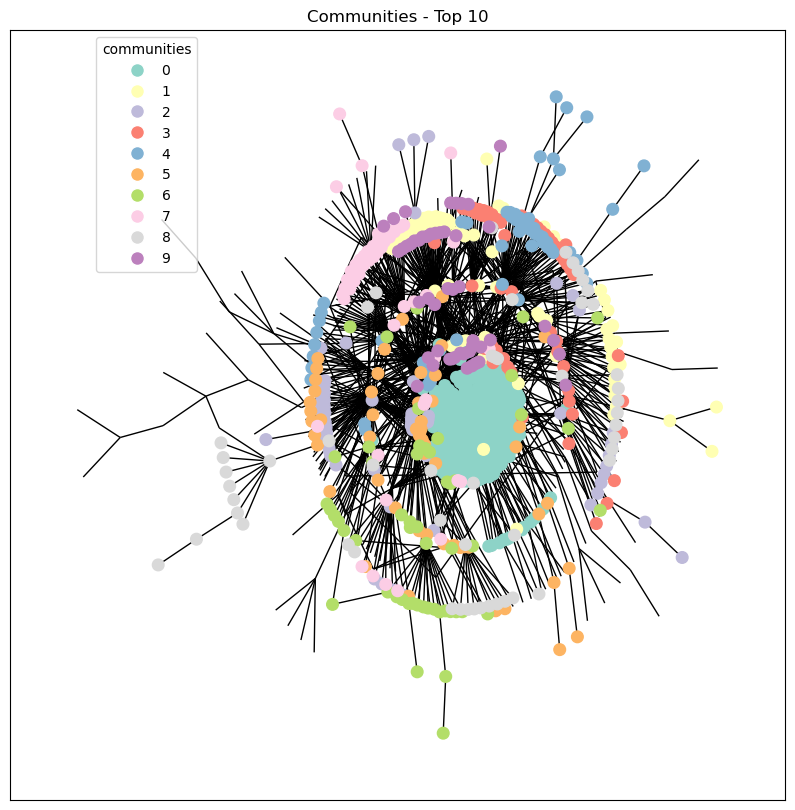

In [11]:
# convert hashtags to frozensets
df_cleaned['hashtag'] = df_cleaned['hashtag'].apply(lambda x: frozenset(x))



# create a graph
G = nx.Graph(random_state=seed)

nodes = df_cleaned[["username", "hashtag"]]
node_list = [
    (row["username"], {"hashtag":row["hashtag"]}) \
    for i, row in nodes.iterrows()
]
G.add_nodes_from(node_list)

# add edges to the graph based on the 'username' and 'interacted_user' columns
for _, row in df_cleaned.iterrows():
    for interacted_user in row['interacted_user']:
        G.add_edge(row['username'], interacted_user)


# apply the Louvain algorithm to detect communities in the graph
communities = nx_comm.louvain_communities(G, seed=seed)

# extract top ten communities

c_sorted = sorted(communities, key=lambda x: len(x), reverse=True)[:10]

# Add coloring to the communities and plot the graph
N_communities = len(c_sorted)
cmap = plt.get_cmap("Set3")
colors = [cmap(i) for i in range(N_communities)]
color_dict = {community:color for community, color in zip(range(N_communities), colors)}



node_list = []
node_colors = []
for i, community in enumerate(c_sorted):
    for node in community:
        node_list.append(node)
        node_colors.append(color_dict[i])

fig, ax = plt.subplots(figsize=(10, 10))

# set fixed positions with kamada kawai 
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(
    G, 
    nodelist=node_list,
    node_color=node_colors,
    node_size=70, 
    with_labels=False,
    pos=pos,
    ax=ax
)

# add a legend
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
                          markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements,
    title="communities",
    loc=1, 
    bbox_to_anchor=[0.25, 1, 0, 0]
)

ax.set_title('Communities - Top 10')
fig.savefig('fig2.png')

"""
# Add coloring to the communities and plot the graph
N_communities = len(communities)
cmap = plt.get_cmap("Set3")
colors = [cmap(i) for i in range(N_communities)]
color_dict = {community:color for community, color in zip(range(N_communities), colors)}



node_list = []
node_colors = []
for i, community in enumerate(communities):
    for node in community:
        node_list.append(node)
        node_colors.append(color_dict[i])

fig, ax = plt.subplots(figsize=(10, 10))

# set fixed positions with kamada kawai 
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx(
    G, 
    nodelist=node_list,
    node_color=node_colors,
    node_size=70, 
    with_labels=False,
    pos=pos,
    ax=ax
)

# add a legend
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
                          markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements,
    title="communities",
    loc=1, 
    bbox_to_anchor=[1.25, 1, 0, 0]
)

#fig.savefig('fig2.png')
"""

## Analysis

In [12]:
# calculate degree assortativity coefficient
assortativity_org = nx.attribute_assortativity_coefficient(G, 'hashtag')

# print result
print("Assortativity coefficient:", round(assortativity_org, 5))


Assortativity coefficient: -0.12254


In [13]:
# permutation testing: do users tend to connect to other users using the same hashtags? 
# we expect they do! -> Assortativity > 0

# set number of permutations to 1000
b = 1000

# calculate assortativity coefficient with sampled hashtags
perm_assortativities = []

for i in range(b):
    hashtags = nodes["hashtag"].sample(frac=1).values
    shuffled_labels = {node:hashtag for node, hashtag in zip(nodes["username"], hashtags)}
    nx.set_node_attributes(G, shuffled_labels, name="hashtag")
    perm_assortativities.append(nx.attribute_assortativity_coefficient(G, "hashtag"))

perm_assortativities = np.array(perm_assortativities)

print("Mean assortativity coefficient (1000 Permutations):", round(perm_assortativities.mean(), 5))

Mean assortativity coefficient (1000 Permutations): -0.13839


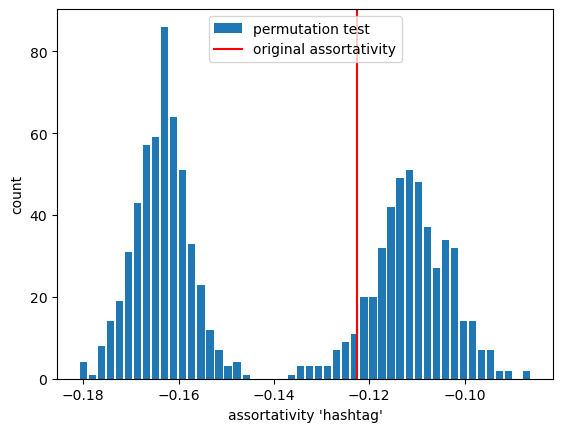

In [14]:
fig, ax = plt.subplots()
ax.hist(perm_assortativities, bins=50, rwidth=0.8, label="permutation test")
ax.axvline(assortativity_org, color="red", label="original assortativity")
ax.set_ylabel("count")
ax.set_xlabel("assortativity 'hashtag'")
ax.legend(loc=9)

fig.savefig('fig3.png')

In [15]:
# calculate p-value for H_0: Assortativity <= 0 and H_1: Assortativity is positive and alpha == 0.05

# since permuted assortativities and original assortativities are all negative, we count how many permuted assortativities are even more negative (more extreme)
p_value = (1 + sum(perm_assortativities < assortativity_org)) / len(perm_assortativities)

print("H_0: Assortativity <= 0\nH_1: Assortativity > 0\nlevel of significance: 0.05")
print("Don't reject H_0 with p =", p_value)
print("Interpretation: It is likely that original assortativity result happened by chance.")

H_0: Assortativity <= 0
H_1: Assortativity > 0
level of significance: 0.05
Don't reject H_0 with p = 0.555
Interpretation: It is likely that original assortativity result happened by chance.


In [16]:
modularity = nx_comm.modularity(G, communities)
print("Modularity score:", round(modularity, 5))

Modularity score: 0.69742


In [17]:
# sort communities based on size in descending order
c_sorted = sorted(communities, key=lambda x: len(x), reverse=True)

for c in c_sorted:
    if len(c) >2:
     print(len(c))
print(f"number of communities: {len(c_sorted)}")

279
80
61
59
56
55
53
52
52
50
47
45
41
39
38
36
34
28
25
24
15
14
5
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
number of communities: 114


In [18]:
# print information on the biggest community
# code block can be repurposed for every community by changing the next 4 lines accordingly

biggestCommunity = c_sorted[0]
setVariable = biggestCommunity
dfVariable = df_cleaned.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

biggestCommunityHashtags = dfVariable['hashtag']

set_biggestCommunityHashtags = set()
for frozen_set in biggestCommunityHashtags:
    for value in frozen_set:
        set_biggestCommunityHashtags.add(value)

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")


most tweets 
heino_matthies     36
Kranich631         12
Sunnynonumber      11
ToBeThatGuy_        7
berlinerzeitung     7
Name: username, dtype: int64

most used hashtags 
(LetzteGeneration)                        317
(Klimakleber)                              28
(lastgeneration)                           22
(LastGeneration)                            8
(LetzteGeneration, letzteDegeneration)      8
Name: hashtag, dtype: int64

most likes 
     username  num of likes  num of retweets   interacted_user                              hashtag
 Perowinger94          3863              613 {AufstandLastGen}                   (LetzteGeneration)
  CaroRackete          3195              484 {AufstandLastGen} (LetzteGeneration, Klimakatastrophe)
greenpeace_de          1853              338 {AufstandLastGen}  (Klimaaktivismus, LetzteGeneration)
most retweets 
     username  num of likes  num of retweets   interacted_user                              hashtag
 Perowinger94          3863              

In [19]:
secondCommunity = c_sorted[1]
setVariable = secondCommunity
dfVariable = df_cleaned.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

secondCommunityHashtags = dfVariable['hashtag']

set_secondCommunityHashtags = set()
for frozen_set in secondCommunityHashtags:
    for value in frozen_set:
        set_secondCommunityHashtags.add(value)

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")

most tweets 
1410_berlin       5
LisaKlaster       4
mannomanleute     4
MBthemaskedone    2
StopAfd           2
Name: username, dtype: int64

most used hashtags 
(LetzteGeneration)                   50
(Klimakleber)                         4
(lastgeneration)                      3
(LetzteGeneration, NieMehrCDUCSU)     2
(LetzteGeneration, Reichsbürger)      2
Name: hashtag, dtype: int64

most likes 
       username  num of likes  num of retweets  interacted_user            hashtag
christophnebgen           287               16 {MarcoBuschmann} (LetzteGeneration)
  M_J_Salzgeber           190               41 {MarcoBuschmann} (LetzteGeneration)
      Ma_Heller           137               23 {MarcoBuschmann} (LetzteGeneration)
most retweets 
       username  num of likes  num of retweets  interacted_user            hashtag
  M_J_Salzgeber           190               41 {MarcoBuschmann} (LetzteGeneration)
      Ma_Heller           137               23 {MarcoBuschmann} (LetzteGeneration)


In [20]:
thirdCommunity = c_sorted[2]
setVariable = thirdCommunity
dfVariable = df_cleaned.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")

most tweets 
HesseMattes       4
VMtronic          3
klatschase        2
hermine_hauck     2
StayWithPeace1    2
Name: username, dtype: int64

most used hashtags 
(LetzteGeneration)                      44
(Klimakleber)                            4
(LetzteGeneration, FridaysForFuture)     3
(LastGeneration)                         2
(LetzteGeneration, Razzia)               2
Name: hashtag, dtype: int64

most likes 
    username  num of likes  num of retweets   interacted_user                                                   hashtag
 DABornhoeft            54                2 {FridayForFuture} (LetzteGeneration, Rechtsstaat, FfF, Polizei, Straftaten)
thisisitA123            32                0 {FridayForFuture}                      (LetzteGeneration, FridaysForFuture)
  Ilona_3639            15                2      {tagesschau}                                        (LetzteGeneration)
most retweets 
     username  num of likes  num of retweets   interacted_user            hashtag
    

In [21]:
fourthCommunity = c_sorted[3]
setVariable = fourthCommunity
dfVariable = df_cleaned.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")

most tweets 
TheNetscape    8
XR_Legal       5
ckXe3          4
AmsHeier       2
LeierKp        2
Name: username, dtype: int64

most used hashtags 
(LetzteGeneration)                                              39
(lastgeneration)                                                 3
(Klimakleber)                                                    2
(schwarwel, LetzteGeneration, klimaaktivismus, Reichsbürger)     2
(LetzteGeneration, Reichsbürger)                                 2
Name: hashtag, dtype: int64

most likes 
     username  num of likes  num of retweets   interacted_user                          hashtag
NikolausBlome           199               21      {derspiegel} (LetzteGeneration, Reichsbürger)
     wegeheld            35               11 {AufstandLastGen} (LetzteGeneration, friedfertige)
     nothilfe            23               10 {AufstandLastGen}               (LetzteGeneration)
most retweets 
     username  num of likes  num of retweets   interacted_user               

In [22]:
fifthCommunity = c_sorted[4]
setVariable = fifthCommunity
dfVariable = df_cleaned.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")

most tweets 
Hanseatengreg      6
Timtam792687961    4
RanaMitra15        3
JKitKat651         3
R_Kopplung         3
Name: username, dtype: int64

most used hashtags 
(LetzteGeneration)                                    37
(LetzteGeneration, FridaysForFuture)                   3
(LetzteGeneration, WirSindAlleDieLetzteGeneration)     2
(LetzteGeneration, letzteDegeneration)                 2
(LetzteGeneration, KlimaRAF, Reichsbürgern)            1
Name: hashtag, dtype: int64

most likes 
       username  num of likes  num of retweets   interacted_user                                                                       hashtag
annanas63322959            54                9        {cducsubt}                                                            (LetzteGeneration)
HeadSoccer_Main            39                2      {tagesschau} (LetzteGeneration, FürAlle, WirSindAlleDieLetzteGeneration, Klimakatastrophe)
     R_Kopplung            36                5 {AufstandLastGen}             

In [23]:
sixthCommunity = c_sorted[5]
setVariable = sixthCommunity
dfVariable = df_cleaned.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")

most tweets 
verena_ramona      16
Freitagsdemonst    10
darji8114           7
mmeffects2022       5
Peter9684873        5
Name: username, dtype: int64

most used hashtags 
(LetzteGeneration)                        52
(Terroristen, Klimakleber)                 3
(LetzteGeneration, NieMehrCDUCSU)          2
(LetzteGeneration, letzteDegeneration)     2
(LetzteGeneration, Tempolimit)             2
Name: hashtag, dtype: int64

most likes 
       username  num of likes  num of retweets                interacted_user                                 hashtag
Freitagsdemonst            28                1 {letztegenAT, AufstandLastGen}                      (LetzteGeneration)
      IsarJesus            24               11              {AufstandLastGen} (niemehrcducsu, LetzteGeneration, Merz)
Freitagsdemonst            24                2              {AufstandLastGen}                      (LetzteGeneration)
most retweets 
       username  num of likes  num of retweets   interacted_user          

In [24]:
seventhCommunity = c_sorted[6]
setVariable = seventhCommunity
dfVariable = df_cleaned.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")

most tweets 
ZweigDietrich      4
a_nordlicht        3
DienerdesVolkes    3
haus_ham           3
lefthand_69        2
Name: username, dtype: int64

most used hashtags 
(LetzteGeneration)                        35
(LetzteGeneration, Reichsbuerger)          3
(Klimakleber)                              3
(LetzteGeneration, letzteDegeneration)     3
(lastgeneration)                           2
Name: hashtag, dtype: int64

most likes 
     username  num of likes  num of retweets   interacted_user                               hashtag
   jdoeschner           202               23 {AufstandLastGen} (LetzteGeneration, Merz, Klimaschutz)
    jam_mi_tz           134               20 {AufstandLastGen}                    (LetzteGeneration)
_Katja_Diehl_           114               27     {berndulrich}                    (LetzteGeneration)
most retweets 
     username  num of likes  num of retweets   interacted_user                                                      hashtag
_Katja_Diehl_          

In [25]:
# Sentiment analysis 


# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate the polarity scores for each tweet and add them as new columns to the dataframe
df_cleaned['polarity_scores'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x))

# Extract the compound score (which ranges from -1 to +1) from the polarity_scores column
df_cleaned['polarity'] = df_cleaned['polarity_scores'].apply(lambda x: x['compound'])

# Print the resulting dataframe
df_cleaned


,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets,interacted_user,hashtag,polarity_scores,polarity
0,0,2022-12-17 23:46:34+00:00,1604261802715611137,https://twitter.com/HaraldV7/status/1604261802...,HaraldV7,Twitter for Android,NaN,@MarcoBuschmann Die Straftaten machen die Poli...,0,0,{MarcoBuschmann},(LetzteGeneration),"{'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...",-0.8316
5,5,2022-12-17 23:20:48+00:00,1604255318690516992,https://twitter.com/Ein_Trixi/status/160425531...,Ein_Trixi,Twitter for Android,NaN,@watch_union @_FriedrichMerz Es ist für Herrn ...,1,0,{watch_union},(LetzteGeneration),"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
7,7,2022-12-17 23:05:54+00:00,1604251567980412932,https://twitter.com/Nette_0870/status/16042515...,Nette_0870,Twitter Web App,Deutschland,@Michael47439567 @AufstandLastGen Die Rhetorik...,0,0,{AufstandLastGen},"(LetzteGeneration, KlimaRAF, Reichsbürgern)","{'neg': 0.317, 'neu': 0.683, 'pos': 0.0, 'comp...",-0.9195
8,8,2022-12-17 22:50:36+00:00,1604247719001952256,https://twitter.com/dingendorf/status/16042477...,dingendorf,Twitter for Android,"Montabaur, Deutschland","@Meikell56 Der Punkt ist doch, dass es so ist,...",3,0,{Meikell56},(LetzteGeneration),"{'neg': 0.081, 'neu': 0.919, 'pos': 0.0, 'comp...",-0.5994
12,12,2022-12-17 22:38:46+00:00,1604244741318758402,https://twitter.com/Kranich631/status/16042447...,Kranich631,Twitter Web App,NaN,@herbertEXgth @MarcoBuschmann Ich habe nicht g...,0,0,"{MarcoBuschmann, herbertEXgth}",(LetzteGeneration),"{'neg': 0.102, 'neu': 0.898, 'pos': 0.0, 'comp...",-0.6360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6642,6642,2022-12-12 06:11:47+00:00,1602184420580118528,https://twitter.com/Vizecancler/status/1602184...,Vizecancler,Twitter Web App,NaN,So viel Humor hätte ich der @AufstandLastGen g...,2,0,{AufstandLastGen},"(Klimaterroristen, Klimakleber, LetzteDegenera...","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compou...",0.3960
6645,6645,2022-12-12 05:40:16+00:00,1602176490220781569,https://twitter.com/AlexxTVYT/status/160217649...,AlexxTVYT,Twitter Web App,Washington DC,@VCD_Nord @AufstandLastGen @VCDeV @VCD_Nordost...,3,0,{AufstandLastGen},(LetzteGeneration),"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6664,6664,2022-12-12 01:22:57+00:00,1602111734105649152,https://twitter.com/JuergenWelker1/status/1602...,JuergenWelker1,Twitter for iPhone,Bayern,@JostMichael555 @e_stonewell @Regendelfin @ste...,0,0,"{zeitonline, JostMichael555}","(Klimakatastrophe, Klimakleber)","{'neg': 0.122, 'neu': 0.878, 'pos': 0.0, 'comp...",-0.5994
6666,6666,2022-12-12 00:59:51+00:00,1602105918182887424,https://twitter.com/Markus_Wolff_55/status/160...,Markus_Wolff_55,Twitter Web App,Auf dem Laufenden hoffentlich!,"@wenig_worte RAF trendet. Siehe auch ""Klima-RA...",0,0,{wenig_worte},(LetzteGeneration),"{'neg': 0.165, 'neu': 0.835, 'pos': 0.0, 'comp...",-0.8439


In [26]:
# sentiment dataframe separated in order to explode the hashtag column
df_sentiment = df_cleaned.copy()

# explode hashtags column to multiple rows
df_sentiment = df_sentiment.explode('hashtag')

# convert hashtags to lowercase
df_sentiment['hashtag'] = df_sentiment['hashtag'].str.lower()

# group by hashtag and calculate mean polarity
polarization = df_sentiment.groupby('hashtag')['polarity'].mean()

# print mean polarity for our three hashtags
print(f"mean polarity letztegeneration: {round(polarization['letztegeneration'], 5)}\nmean polarity klimakleber: {round(polarization['klimakleber'], 5)}\nmean polarity lastgeneration: {round(polarization['lastgeneration'], 5)}")

mean polarity letztegeneration: -0.44299
mean polarity klimakleber: -0.38688
mean polarity lastgeneration: -0.38418


In [27]:
print(len(df_cleaned))
print(len(df_cleaned.loc[df_cleaned['polarity_scores']=={'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]))

# drop all rows where sentiment analysis returns exactly 0 -> example tweet: "#GrüneSekte + #LetzteGeneration https://t.co/ecaXzZ5WG2"

df_validSentiments = df_cleaned.loc[df_cleaned['polarity_scores']!={'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]
print(len(df_cleaned))
print(len(df_validSentiments))


1739
612
1739
1127


In [28]:
# create a graph again with polarity column
G_2 = nx.Graph()

nodes = df_validSentiments[["username", "polarity"]]
node_list = [
    (row["username"], {"polarity":row["polarity"]}) \
    for i, row in nodes.iterrows()
]
G_2.add_nodes_from(node_list)

# add edges to the graph based on the 'username' and 'interacted_user' columns
for _, row in df_validSentiments.iterrows():
    for interacted_user in row['interacted_user']:
        G_2.add_edge(row['username'], interacted_user)

# calculate degree assortativity coefficient
assortativity_org_2 = nx.attribute_assortativity_coefficient(G_2, 'polarity')

# print result
print("Assortativity coefficient:", round(assortativity_org_2, 5))

Assortativity coefficient: -0.16574


In [29]:
# Assortativity testing + permutation tests for column sentiments instead of hashtags
# we expect no assortativity -> assortativity = 0

# set number of permutations to 1000
b = 1000

# calculate assortativity coefficient with sampled hashtags
perm_assortativities = []

for i in range(b):
    polarities = nodes["polarity"].sample(frac=1).values
    shuffled_labels = {node:polarity for node, polarity in zip(nodes["username"], polarities)}
    nx.set_node_attributes(G_2, shuffled_labels, name="polarity")
    perm_assortativities.append(nx.attribute_assortativity_coefficient(G_2, "polarity"))

perm_assortativities = np.array(perm_assortativities)

print("Mean assortativity coefficient (1000 Permutations):", round(perm_assortativities.mean(), 5))

Mean assortativity coefficient (1000 Permutations): -0.14482


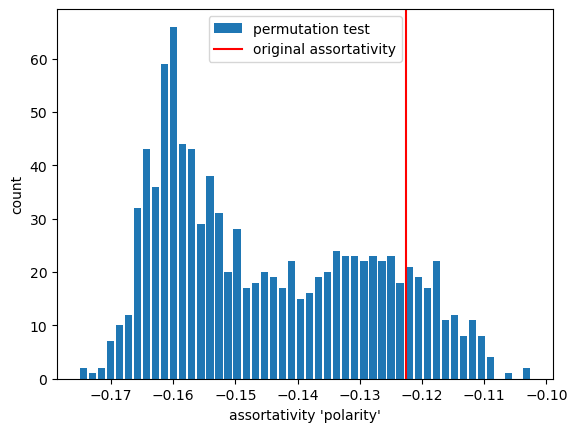

In [30]:
fig, ax = plt.subplots()
ax.hist(perm_assortativities, bins=50, rwidth=0.8, label="permutation test")
ax.axvline(assortativity_org, color="red", label="original assortativity")
ax.set_ylabel("count")
ax.set_xlabel("assortativity 'polarity'")
ax.legend(loc=9)

fig.savefig('fig4.png')

In [31]:
# calculate p-value for H_0: Assortativity <> 0 and H_1: Assortativity = 0 and alpha == 0.05

# since permuted assortativities and original assortativities are all negative, we count how many permuted assortativities are even more negative 
p_value = (1 + sum(perm_assortativities < assortativity_org)) / len(perm_assortativities)

print("H_0: Assortativity <> 0\nH_1: Assortativity = 0\nlevel of significance: 0.05")
print("Don't reject H_0 with p =", p_value)
print("Interpretation: It is likely that original assortativity result happened by chance.")

H_0: Assortativity <> 0
H_1: Assortativity = 0
level of significance: 0.05
Don't reject H_0 with p = 0.869
Interpretation: It is likely that original assortativity result happened by chance.


# Dataframe exclusively  containing the hashtags "letztegeneration", "klimakleber" and "lastgeneration"

In [32]:
# in order to compare if the results above change if our dataset only contains our three hashtags
# the data frame is filtered and tests are repeated

our_hashtags = ['letztegeneration', 'klimakleber', 'lastgeneration']

# filter the DataFrame to only contain rows with the three specific hashtags
final_df = df_sentiment[df_sentiment['hashtag'].isin(our_hashtags)]

# filter the DataFrame to only contain rows with the three specific hashtags whilst dropping all tweets where at least one other hashtag  is included
to_drop = df_sentiment[~df_sentiment['hashtag'].isin(our_hashtags)].url
only_df = df_sentiment[~df_sentiment['url'].isin(to_drop)]

only_df

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets,interacted_user,hashtag,polarity_scores,polarity
0,0,2022-12-17 23:46:34+00:00,1604261802715611137,https://twitter.com/HaraldV7/status/1604261802...,HaraldV7,Twitter for Android,NaN,@MarcoBuschmann Die Straftaten machen die Poli...,0,0,{MarcoBuschmann},letztegeneration,"{'neg': 0.238, 'neu': 0.762, 'pos': 0.0, 'comp...",-0.8316
5,5,2022-12-17 23:20:48+00:00,1604255318690516992,https://twitter.com/Ein_Trixi/status/160425531...,Ein_Trixi,Twitter for Android,NaN,@watch_union @_FriedrichMerz Es ist für Herrn ...,1,0,{watch_union},letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
8,8,2022-12-17 22:50:36+00:00,1604247719001952256,https://twitter.com/dingendorf/status/16042477...,dingendorf,Twitter for Android,"Montabaur, Deutschland","@Meikell56 Der Punkt ist doch, dass es so ist,...",3,0,{Meikell56},letztegeneration,"{'neg': 0.081, 'neu': 0.919, 'pos': 0.0, 'comp...",-0.5994
12,12,2022-12-17 22:38:46+00:00,1604244741318758402,https://twitter.com/Kranich631/status/16042447...,Kranich631,Twitter Web App,NaN,@herbertEXgth @MarcoBuschmann Ich habe nicht g...,0,0,"{MarcoBuschmann, herbertEXgth}",letztegeneration,"{'neg': 0.102, 'neu': 0.898, 'pos': 0.0, 'comp...",-0.6360
16,16,2022-12-17 22:17:57+00:00,1604239501659873280,https://twitter.com/Kranich631/status/16042395...,Kranich631,Twitter Web App,NaN,"@herbertEXgth @MarcoBuschmann Als harmlos, ist...",1,0,"{MarcoBuschmann, herbertEXgth}",letztegeneration,"{'neg': 0.276, 'neu': 0.724, 'pos': 0.0, 'comp...",-0.6360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6617,6617,2022-12-12 07:21:56+00:00,1602202073327669248,https://twitter.com/gunnar_ror/status/16022020...,gunnar_ror,Twitter for Android,Bayern,@AufstandLastGen #LetzteGeneration ❤️👍,1,0,{AufstandLastGen},letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6625,6625,2022-12-12 07:03:04+00:00,1602197323743895552,https://twitter.com/realJanE19/status/16021973...,realJanE19,Twitter for iPad,NaN,@Kricke1905 Treffen sich zwei Typen der #Letzt...,1,0,{Kricke1905},letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6645,6645,2022-12-12 05:40:16+00:00,1602176490220781569,https://twitter.com/AlexxTVYT/status/160217649...,AlexxTVYT,Twitter Web App,Washington DC,@VCD_Nord @AufstandLastGen @VCDeV @VCD_Nordost...,3,0,{AufstandLastGen},letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6666,6666,2022-12-12 00:59:51+00:00,1602105918182887424,https://twitter.com/Markus_Wolff_55/status/160...,Markus_Wolff_55,Twitter Web App,Auf dem Laufenden hoffentlich!,"@wenig_worte RAF trendet. Siehe auch ""Klima-RA...",0,0,{wenig_worte},letztegeneration,"{'neg': 0.165, 'neu': 0.835, 'pos': 0.0, 'comp...",-0.8439


In [33]:
# group by hashtag and calculate mean polarity
polarization = only_df.groupby('hashtag')['polarity'].mean()

# print mean polarity for our three hashtags
print(f"mean polarity letztegeneration: {round(polarization['letztegeneration'], 5)}\nmean polarity klimakleber: {round(polarization['klimakleber'], 5)}\nmean polarity lastgeneration: {round(polarization['lastgeneration'], 5)}")

mean polarity letztegeneration: -0.4705
mean polarity klimakleber: -0.40922
mean polarity lastgeneration: -0.34769


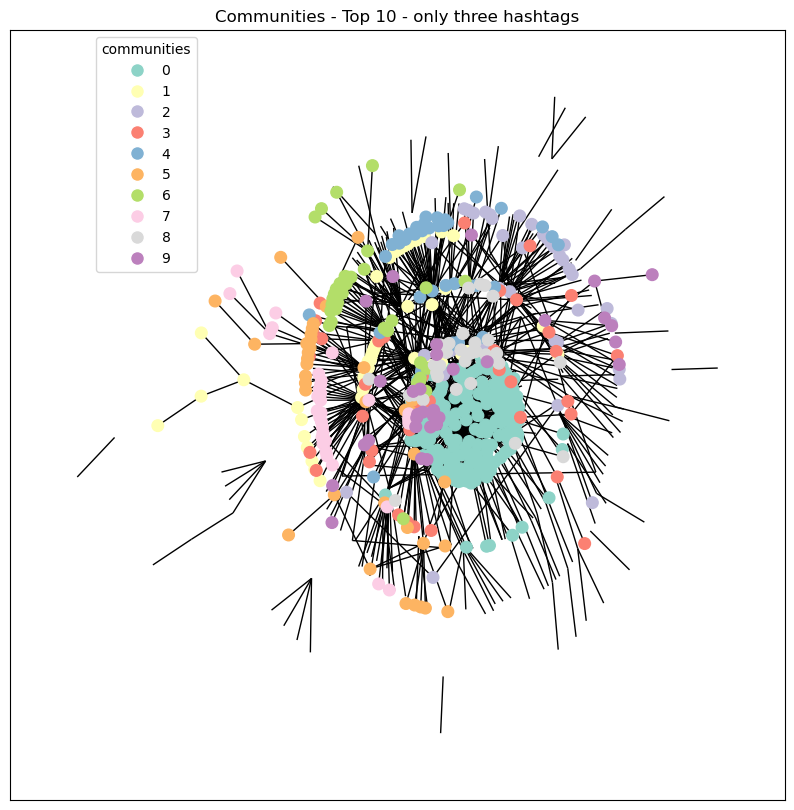

In [34]:
# create a graph
G_th = nx.Graph(random_state=seed)

nodes = only_df[["username", "hashtag"]]
node_list = [
    (row["username"], {"hashtag":row["hashtag"]}) \
    for i, row in nodes.iterrows()
]
G_th.add_nodes_from(node_list)

# add edges to the graph based on the 'username' and 'interacted_user' columns
for _, row in only_df.iterrows():
    for interacted_user in row['interacted_user']:
        G_th.add_edge(row['username'], interacted_user)

# apply the Louvain algorithm to detect communities in the graph
communities = nx_comm.louvain_communities(G_th, seed=seed)

c_sorted = sorted(communities, key=lambda x: len(x), reverse=True)[:10]

# Add coloring to the communities and plot the graph
N_communities = len(c_sorted)
cmap = plt.get_cmap("Set3")
colors = [cmap(i) for i in range(N_communities)]
color_dict = {community:color for community, color in zip(range(N_communities), colors)}


node_list = []
node_colors = []
for i, community in enumerate(c_sorted):
    for node in community:
        node_list.append(node)
        node_colors.append(color_dict[i])

        
pos = nx.kamada_kawai_layout(G)

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx(
    G_th, 
    nodelist=node_list,
    node_color=node_colors,
    node_size=70, 
    with_labels=False,
    pos=pos,
    ax=ax
)

# add a legend
legend_elements = [Line2D([0], [0], marker='o', color="w", label=key,
                          markerfacecolor=val, markersize=10) for key, val in color_dict.items()]
ax.legend(
    handles=legend_elements,
    title="communities",
    loc=1, 
    bbox_to_anchor=[0.25, 1, 0, 0]
)

ax.set_title('Communities - Top 10 - only three hashtags')
fig.savefig('fig5.png')

In [35]:
# calculate degree assortativity coefficient
assortativity_org = nx.attribute_assortativity_coefficient(G_th, 'hashtag')

# print result
print("Assortativity coefficient:", round(assortativity_org, 5))


Assortativity coefficient: -0.30919


In [36]:
# permutation testing: do users tend to connect to other users using the same hashtags? 
# we expect they do! -> Assortativity > 0

# set number of permutations to 1000
b = 1000

# calculate assortativity coefficient with sampled hashtags
perm_assortativities = []

for i in range(b):
    hashtags = nodes["hashtag"].sample(frac=1).values
    shuffled_labels = {node:hashtag for node, hashtag in zip(nodes["username"], hashtags)}
    nx.set_node_attributes(G_th, shuffled_labels, name="hashtag")
    perm_assortativities.append(nx.attribute_assortativity_coefficient(G_th, "hashtag"))

perm_assortativities = np.array(perm_assortativities)

print("Mean assortativity coefficient (1000 Permutations):", round(perm_assortativities.mean(), 5))

Mean assortativity coefficient (1000 Permutations): -0.31617


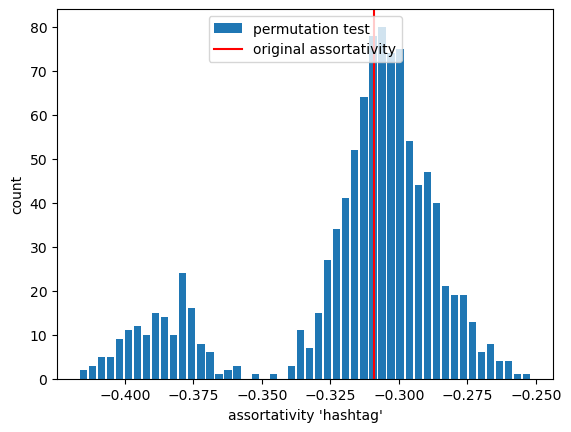

In [37]:
fig, ax = plt.subplots()
ax.hist(perm_assortativities, bins=50, rwidth=0.8, label="permutation test")
ax.axvline(assortativity_org, color="red", label="original assortativity")
ax.set_ylabel("count")
ax.set_xlabel("assortativity 'hashtag'")
ax.legend(loc=9)

#fig.savefig('fig5.png')

In [38]:
# calculate p-value for H_0: Assortativity <= 0 and H_1: Assortativity is positive and alpha == 0.05

# since permuted assortativities and original assortativities are all negative, we count how many permuted assortativities are even more negative (more extreme)
p_value = (1 + sum(perm_assortativities < assortativity_org)) / len(perm_assortativities)

print("H_0: Assortativity <= 0\nH_1: Assortativity > 0\nlevel of significance: 0.05")
print("Don't reject H_0 with p =", p_value)
print("Interpretation: It is likely that original assortativity result happened by chance.")

H_0: Assortativity <= 0
H_1: Assortativity > 0
level of significance: 0.05
Don't reject H_0 with p = 0.456
Interpretation: It is likely that original assortativity result happened by chance.


In [39]:
modularity = nx_comm.modularity(G_th, communities)
print("Modularity score:", round(modularity, 5))

Modularity score: 0.745


In [40]:
# sort communities based on size in descending order
c_sorted = sorted(communities, key=lambda x: len(x), reverse=True)

for c in c_sorted:
    if len(c) >2:
     print(len(c))
print(f"number of communities: {len(c_sorted)}")

180
42
39
38
37
36
34
33
32
32
29
28
26
23
23
21
20
19
10
9
8
7
6
5
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
number of communities: 111


In [41]:
# print information on the biggest community
# code block can be repurposed for every community by changing the next 4 lines accordingly

biggestCommunity = c_sorted[0]
setVariable = biggestCommunity
dfVariable = only_df.copy()

mask = dfVariable.apply(lambda row: any(name in row['username'] or name in row['interacted_user'] for name in setVariable), axis=1)

# filter out the rows that don't meet the condition
dfVariable = dfVariable.loc[mask]

biggestCommunityHashtags = dfVariable['hashtag']

set_biggestCommunityHashtags = set()
for frozen_set in biggestCommunityHashtags:
    for value in frozen_set:
        set_biggestCommunityHashtags.add(value)

print(f"most tweets \n{dfVariable['username'].value_counts().head(5)}\n")
print(f"most used hashtags \n{dfVariable['hashtag'].value_counts().head(5)}\n")
top_3 = dfVariable.nlargest(3, 'num of likes').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most likes \n{top_3.to_string(index=False)}")
top_3 = dfVariable.nlargest(3, 'num of retweets').drop(['tweet', 'location','source', 'url', 'ID', 'Date', 'Unnamed: 0'], axis=1)
print(f"most retweets \n{top_3.to_string(index=False)}")

dfVariable

most tweets 
heino_matthies     17
Kranich631         11
Sunnynonumber      11
berlinerzeitung     7
thisisitA123        6
Name: username, dtype: int64

most used hashtags 
letztegeneration    336
klimakleber          35
lastgeneration       33
Name: hashtag, dtype: int64

most likes 
       username  num of likes  num of retweets                    interacted_user          hashtag                                               polarity_scores  polarity
   Perowinger94          3863              613                  {AufstandLastGen} letztegeneration {'neg': 0.191, 'neu': 0.809, 'pos': 0.0, 'compound': -0.8316}   -0.8316
         VOSP10           289                4                  {AufstandLastGen}      klimakleber         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}    0.0000
berlinerzeitung           175               42 {carla_hinrichs_, AufstandLastGen} letztegeneration {'neg': 0.157, 'neu': 0.843, 'pos': 0.0, 'compound': -0.5994}   -0.5994
most retweets 
       username

,Unnamed: 0,Date,ID,url,username,source,location,tweet,num of likes,num of retweets,interacted_user,hashtag,polarity_scores,polarity
34,34,2022-12-17 20:54:34+00:00,1604218519276732417,https://twitter.com/ScientistRebel1/status/160...,ScientistRebel1,Twitter for Android,NaN,What's up in Germany? A thread. 🧵\n\nOn Tuesda...,121,45,{AufstandLastGen},lastgeneration,"{'neg': 0.181, 'neu': 0.744, 'pos': 0.074, 'co...",-0.5574
52,52,2022-12-17 19:20:40+00:00,1604194886202273795,https://twitter.com/wertyXXXXXXXX/status/16041...,wertyXXXXXXXX,Twitter for Android,NaN,@infoluencer Die #LetzteGeneration @AufstandLa...,0,0,{AufstandLastGen},letztegeneration,"{'neg': 0.358, 'neu': 0.642, 'pos': 0.0, 'comp...",-0.5994
65,65,2022-12-17 18:18:52+00:00,1604179334364680197,https://twitter.com/MarkTeachah/status/1604179...,MarkTeachah,Twitter Web App,NaN,@Bundeskanzler Sicherer. Für etwa 1 Tag reicht...,0,0,{AufstandLastGen},klimakleber,"{'neg': 0.376, 'neu': 0.624, 'pos': 0.0, 'comp...",-0.9282
85,85,2022-12-17 16:59:55+00:00,1604159468010455041,https://twitter.com/Giftfrosch100/status/16041...,Giftfrosch100,Twitter for Android,NaN,@AufstandLastGen Demokratie muss fairerweise a...,0,0,{AufstandLastGen},klimakleber,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
110,110,2022-12-17 15:43:25+00:00,1604140215500771331,https://twitter.com/Kranich631/status/16041402...,Kranich631,Twitter Web App,NaN,@endfossil_goe @AufstandLastGen @eg_goe @XR_Go...,0,0,"{endfossil_goe, LuetziBleibt, AufstandLastGen}",letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,6605,2022-12-12 07:46:56+00:00,1602208365454704640,https://twitter.com/DirSchi68/status/160220836...,DirSchi68,Twitter Web App,NaN,@HeadSoccer_Main @AufstandLastGen #LetzteGener...,4,0,"{HeadSoccer_Main, AufstandLastGen}",letztegeneration,"{'neg': 0.102, 'neu': 0.898, 'pos': 0.0, 'comp...",-0.1511
6609,6609,2022-12-12 07:38:48+00:00,1602206319158648834,https://twitter.com/HeadSoccer_Main/status/160...,HeadSoccer_Main,Twitter Web App,Unbekannt,"@AufstandLastGen Wer hier mit ""geht Arbeiten"" ...",42,2,{AufstandLastGen},letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6617,6617,2022-12-12 07:21:56+00:00,1602202073327669248,https://twitter.com/gunnar_ror/status/16022020...,gunnar_ror,Twitter for Android,Bayern,@AufstandLastGen #LetzteGeneration ❤️👍,1,0,{AufstandLastGen},letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
6645,6645,2022-12-12 05:40:16+00:00,1602176490220781569,https://twitter.com/AlexxTVYT/status/160217649...,AlexxTVYT,Twitter Web App,Washington DC,@VCD_Nord @AufstandLastGen @VCDeV @VCD_Nordost...,3,0,{AufstandLastGen},letztegeneration,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


In [42]:
DeepnoteChart(dfVariable, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#e45756","tooltip":true},"encoding":{"x":{"sort":{"order":"descending","encoding":"y"},"type":"nominal","field":"username","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"aggregate":"count","formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

NameError: name 'DeepnoteChart' is not defined

In [ ]:
only_df['hashtag'].value_counts()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7672e300-276f-44e9-a062-2223f4709f66' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>